In [1]:
!pip install pandas
!pip install networkx
!pip install scipy 

In [2]:
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

G = nx.Graph()

with open('systems.json') as f:  
    data = json.load(f)
df=pd.DataFrame(data)

with open('planets.json') as f:  
    data = json.load(f)
df_planets=pd.DataFrame(data)
#print(df)

#for row in range(len(df)):
#  print(df.at[row, 'Name'])

In [3]:
#print(df_planets.dtypes)
# df_planets

In [4]:
id_to_name = {}
for index, row in df.iterrows():
    id_to_name[row["SystemId"]] = row["Name"]

naturalID_to_name = {}
for index, row in df.iterrows():
    naturalID_to_name[row["NaturalId"]] = row["Name"]

In [5]:
import csv

cheap_planets_nearby_2_jumps = {}
cheap_planets_nearby_1_jump = {}
for index, row in df.iterrows():
    cheap_planets_nearby_2_jumps[row["Name"]] = 0
    cheap_planets_nearby_1_jump[row["Name"]] = 0

with open("cheap_planets_nearby_system.csv", 'r') as file:
    reader = csv.reader(file)
    
    # Read and print headers
    headers = next(reader)
    #print("Headers:", headers)
    
    # Read and print data
    for row in reader:
        #print(row)
        cheap_planets_nearby_2_jumps[naturalID_to_name[row[0]]] = int(row[3])
        cheap_planets_nearby_1_jump[naturalID_to_name[row[0]]] = int(row[2])
    

In [6]:
len(cheap_planets_nearby_2_jumps)

637

In [7]:
len(id_to_name)

637

In [8]:


def FindSystem(name):
    for index, row in df.iterrows():
        if row["Name"] == name: #weird type stuff????
            return row # returns a dataframe, I think?

def FindPlanetsIn(systemDf):
    matches = []
    for index, row in df_planets.iterrows():
        if id_to_name[row["SystemId"]] == systemDf["Name"]:
            matches.append(row)
    return matches
        
ANT_node = "Antares I"
BEN_node = "Benten"
MOR_node = "Moria"

fullGraph = nx.Graph()
#G.from_pandas_dataframe(df)
#list(G.nodes)

# fill graph object with nodes
for index, row in df.iterrows():
    fullGraph.add_node(row["Name"])

# and connections
for index, row in df.iterrows():
    for connection in row["Connections"]:
        #print(row["Name"] + " to " + id_to_name[connection["ConnectingId"]])
        fullGraph.add_edge(row["Name"], id_to_name[connection["ConnectingId"]])
    
print("Node count " + str(fullGraph.number_of_nodes()) + " edge count: " + str(fullGraph.number_of_edges()))

# maybe we are only interested in the systems near ANT

# within N jumps of ANT
def filterWithin15ANT(systemName):
    pathLen = nx.shortest_path_length(fullGraph, ANT_node, systemName)
    # print("Distance from " + systemName + " is " + str(pathLen))
    return pathLen < 5

# planets closer to ANT than they are to other CXes
def filterCloserToANT(systemName):
    distANT = nx.shortest_path_length(fullGraph, ANT_node, systemName)
    distBEN = nx.shortest_path_length(fullGraph, BEN_node, systemName)
    distMOR = nx.shortest_path_length(fullGraph, MOR_node, systemName)
    # print("Distance from " + systemName + " is " + str(pathLen))
    return distANT <= distBEN and distANT <= distMOR

# all planets
def filterAll(systemName):
    return True


def FilterByFunction(filterPlanetFunction):
    selected_nodes = []
    for index, row in df.iterrows():
        systemName = row["Name"]
        if(filterPlanetFunction(systemName)):
            selected_nodes.append(systemName)
        
#     print("~~~~~~~~~~~~~~~~~~~")
    subGraph = fullGraph.subgraph(selected_nodes)
#     print("after filter: Node count " + str(subGraph.number_of_nodes()) + " edge count: " + str(subGraph.number_of_edges()))
    return subGraph

Node count 637 edge count: 838


In [9]:
# find game specified xy positions:
game_pos = {}
for index, row in df.iterrows():
    if row["Name"] in fullGraph.nodes():
#         print("Find pos for " + row["Name"])
        game_pos[row["Name"]] = [row["PositionX"] / 1000.0 , row["PositionY"] / 1000.0]

In [10]:
# find systems with nice planets.
planet_habitable = {}
planet_good_water = {}
planet_COGC = {}
planet_fertile = {}

for index, row in df_planets.iterrows():
    
    systemName = id_to_name[row["SystemId"]]
    planetName = row["PlanetName"]

    planet_habitable.setdefault(systemName, 0)
    planet_good_water.setdefault(systemName, 0)
    planet_COGC.setdefault(systemName, 0)
    planet_fertile.setdefault(systemName, 0)

    if(row["Fertility"] > -1):
#         print("Fertile: " + str(row["Fertility"]) + " on " + planetName + " in " + systemName)
        planet_fertile[systemName] = planet_fertile.get(systemName, 0) + 1

    malusCount = 0
    pressure = row["Pressure"]
    temperature = row["Temperature"]
    gravity = row["Gravity"]

    if(gravity > 2.5 or gravity < 0.25):
        malusCount += 1
    if(temperature > 75 or temperature < -25):
        malusCount += 1
    # low pressure is fine, so or pressure < 0.25 is okay!
#    if(pressure > 2.0 or pressure < 0.25 ):
#        malusCount += 1
    if(pressure > 2.0 ):
        malusCount += 1

    if(malusCount == 0):
        planet_habitable[systemName] = planet_habitable.get(systemName, 0) + 1
        #print(str(malusCount) + " for pressure " + str(pressure) + " on " + planetName)

    #filteredValue = dict(nx.single_source_shortest_path_length(G, favoredNode))

    for reso in row["Resources"]:
        #print("Planet " + planetName + " has " + str(reso))
        #water
        if reso["MaterialId"] == "ec8dbb1d3f51d89c61b6f58fdd64a7f0" \
            and reso["ResourceType"] == "LIQUID" \
            and reso["Factor"] > 0.36: 
            # ResourceType = LIQUID Factor > 0.36 (Harmonia levels)
            planet_good_water[systemName] = 1
            #print("Found water on " + planetName)


    #consider it occupied if it has a COGC
    #print(planetName + " in " + systemName + " has COGC: " + str(row["HasChamberOfCommerce"]))
    if row["HasChamberOfCommerce"]:
        planet_COGC[systemName] = planet_COGC.get(systemName, 0) + 1
        #print("Set!")


In [11]:

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

def PlotGraph(G, drawFunc, s):
    #pos = game_pos
    pos = nx.kamada_kawai_layout(G, pos=game_pos)

    plt.clf()
    plt.figure(figsize=(40,40))

    print("Drawing: Node count " + str(G.number_of_nodes()) + " edge count: " + str(G.number_of_edges()))

    drawFunc(G, pos)

    label_ratio = 1.0/16.0
    pos_labels = {}
    for aNode in G.nodes():
        #Get the node's position from the layout
        x,y = pos[aNode]
        #Get the node's neighbourhood
        N = G[aNode]
        #Find the centroid of the neighbourhood. The centroid is the average of the Neighbourhood's node's x and y coordinates respectively.
        #Please note: This could be optimised further
        cx = sum(map(lambda x:pos[x][0], N)) / len(pos)
        cy = sum(map(lambda x:pos[x][1], N)) / len(pos)
        #Get the centroid's 'direction' or 'slope'. That is, the direction TOWARDS the centroid FROM aNode.
        slopeY = (y-cy)
        slopeX = (x-cx)
        #Position the label at some distance along this line. Here, the label is positioned at about 1/8th of the distance.
        pos_labels[aNode] = [x+slopeX*label_ratio, y+slopeY*label_ratio]

        #ignore all the math we did above and just offset it from the planet. 
        pos_labels[aNode] = [x + 0.01, y + 0.01]

    # pos = pos_labels
    #  "ec": "k",
    label_options = { "fc": "white", "alpha": 0.2}
    nx.draw_networkx_labels(G, pos_labels, font_size=7, bbox=label_options)

    plt.title("Prosperous Universe\nmap by Archiel\n" + s)
    plt.margins(0.0) 
    # plt.text(0.5, 0.98, s, horizontalalignment="center")
    plt.tight_layout()
    plt.show()

Drawing: Node count 226 edge count: 297


<Figure size 432x288 with 0 Axes>

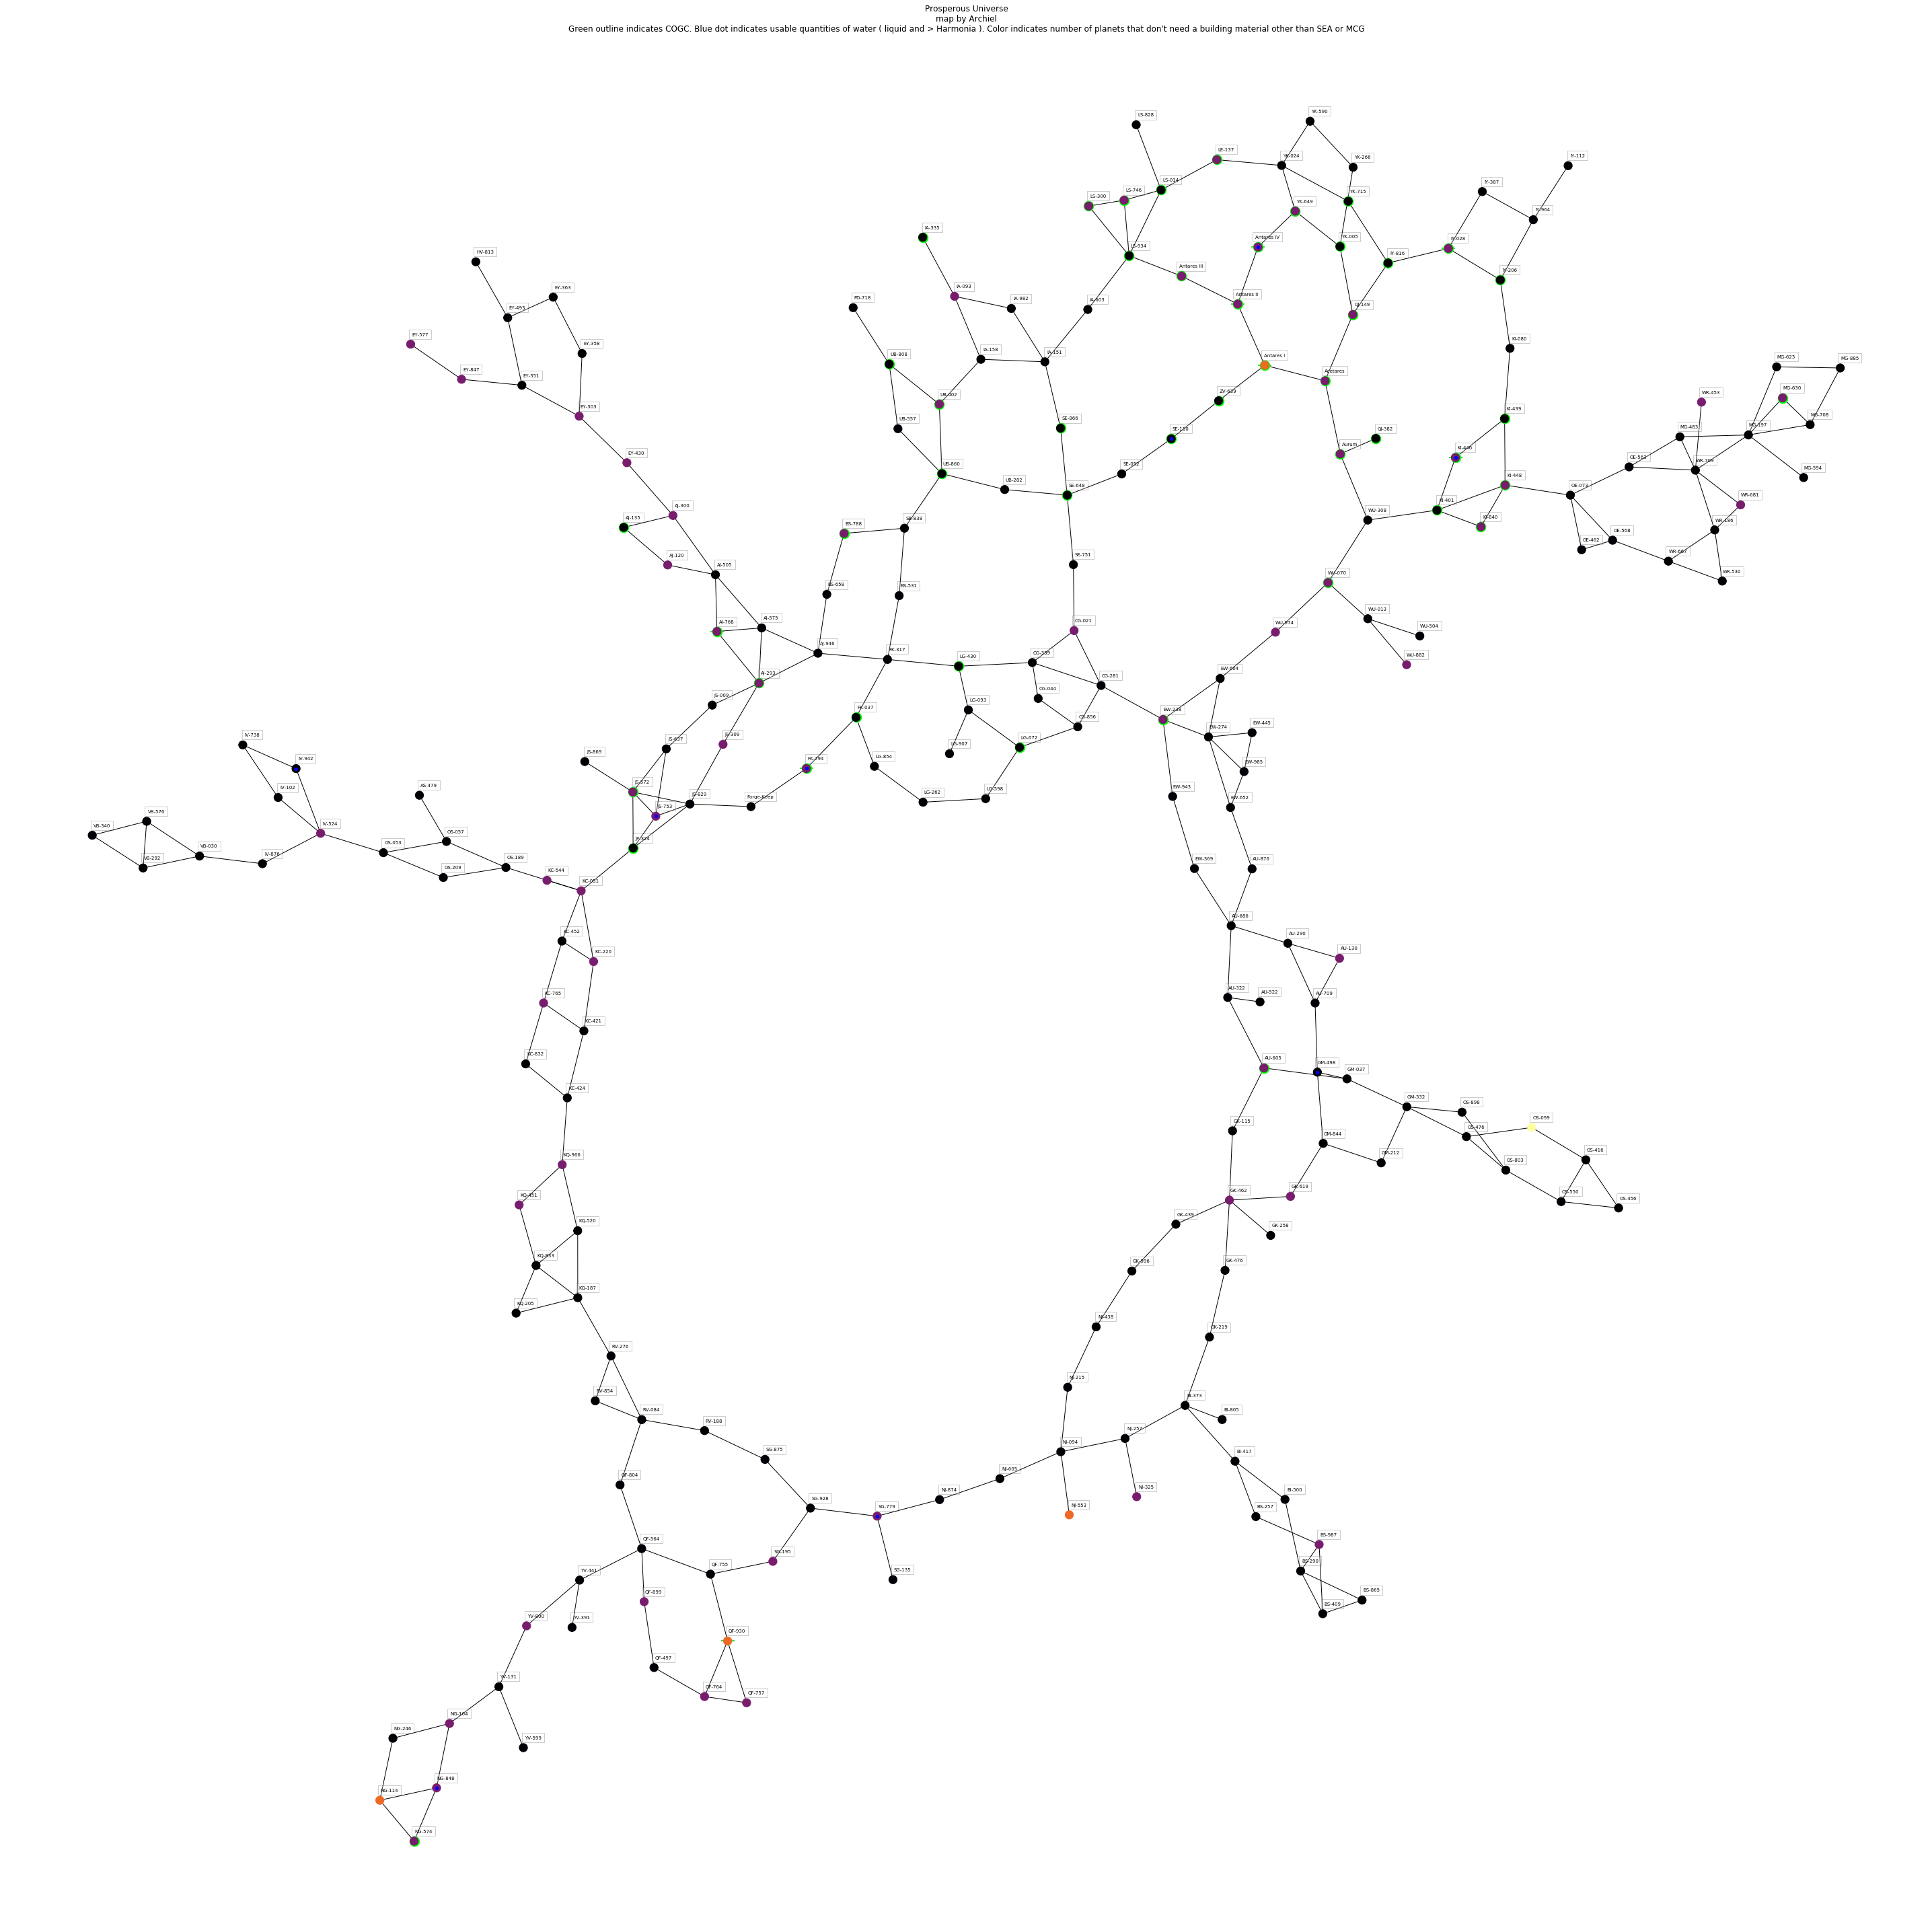

In [18]:
def drawSummary(G, pos):
    
    # draw extra nodes to create outlines and dots inside our real nodes.
    matchingKeys = [k for k,v in planet_fertile.items() if float(v) >= 1]
    f1 = intersection(G.nodes, list(matchingKeys))
    nx.draw_networkx_nodes(G, pos, node_size=410, node_shape="_", node_color='#00CC00', nodelist=f1)
    
    # draw extra nodes to create outlines and dots inside our real nodes.
    matchingKeys = [k for k,v in planet_COGC.items() if float(v) >= 1]
    f1 = intersection(G.nodes, list(matchingKeys))
    nx.draw_networkx_nodes(G, pos, node_size=210, node_color='#00FF00', nodelist=f1)

    f1 = intersection(G.nodes, list(planet_habitable.keys()))
    colorListValues = [planet_habitable[k] for k in f1]
    nx.draw(G, pos, node_size=150, with_labels=False, nodelist=f1, node_color=colorListValues, cmap="inferno")

    # blue nodes
    matchingKeys = [k for k,v in planet_good_water.items() if float(v) >= 1]
    f1 = intersection(G.nodes, list(matchingKeys))
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color='#0000FF', nodelist=f1)
  
graph = FilterByFunction(filterCloserToANT)
#graph = FilterByFunction(filterAll)
s = "Green outline indicates COGC. Blue dot indicates usable quantities of water ( liquid and > Harmonia ). Color indicates number of planets that don't need a building material other than SEA or MCG"
PlotGraph(graph, drawSummary, s)


Drawing: Node count 637 edge count: 838


<Figure size 432x288 with 0 Axes>

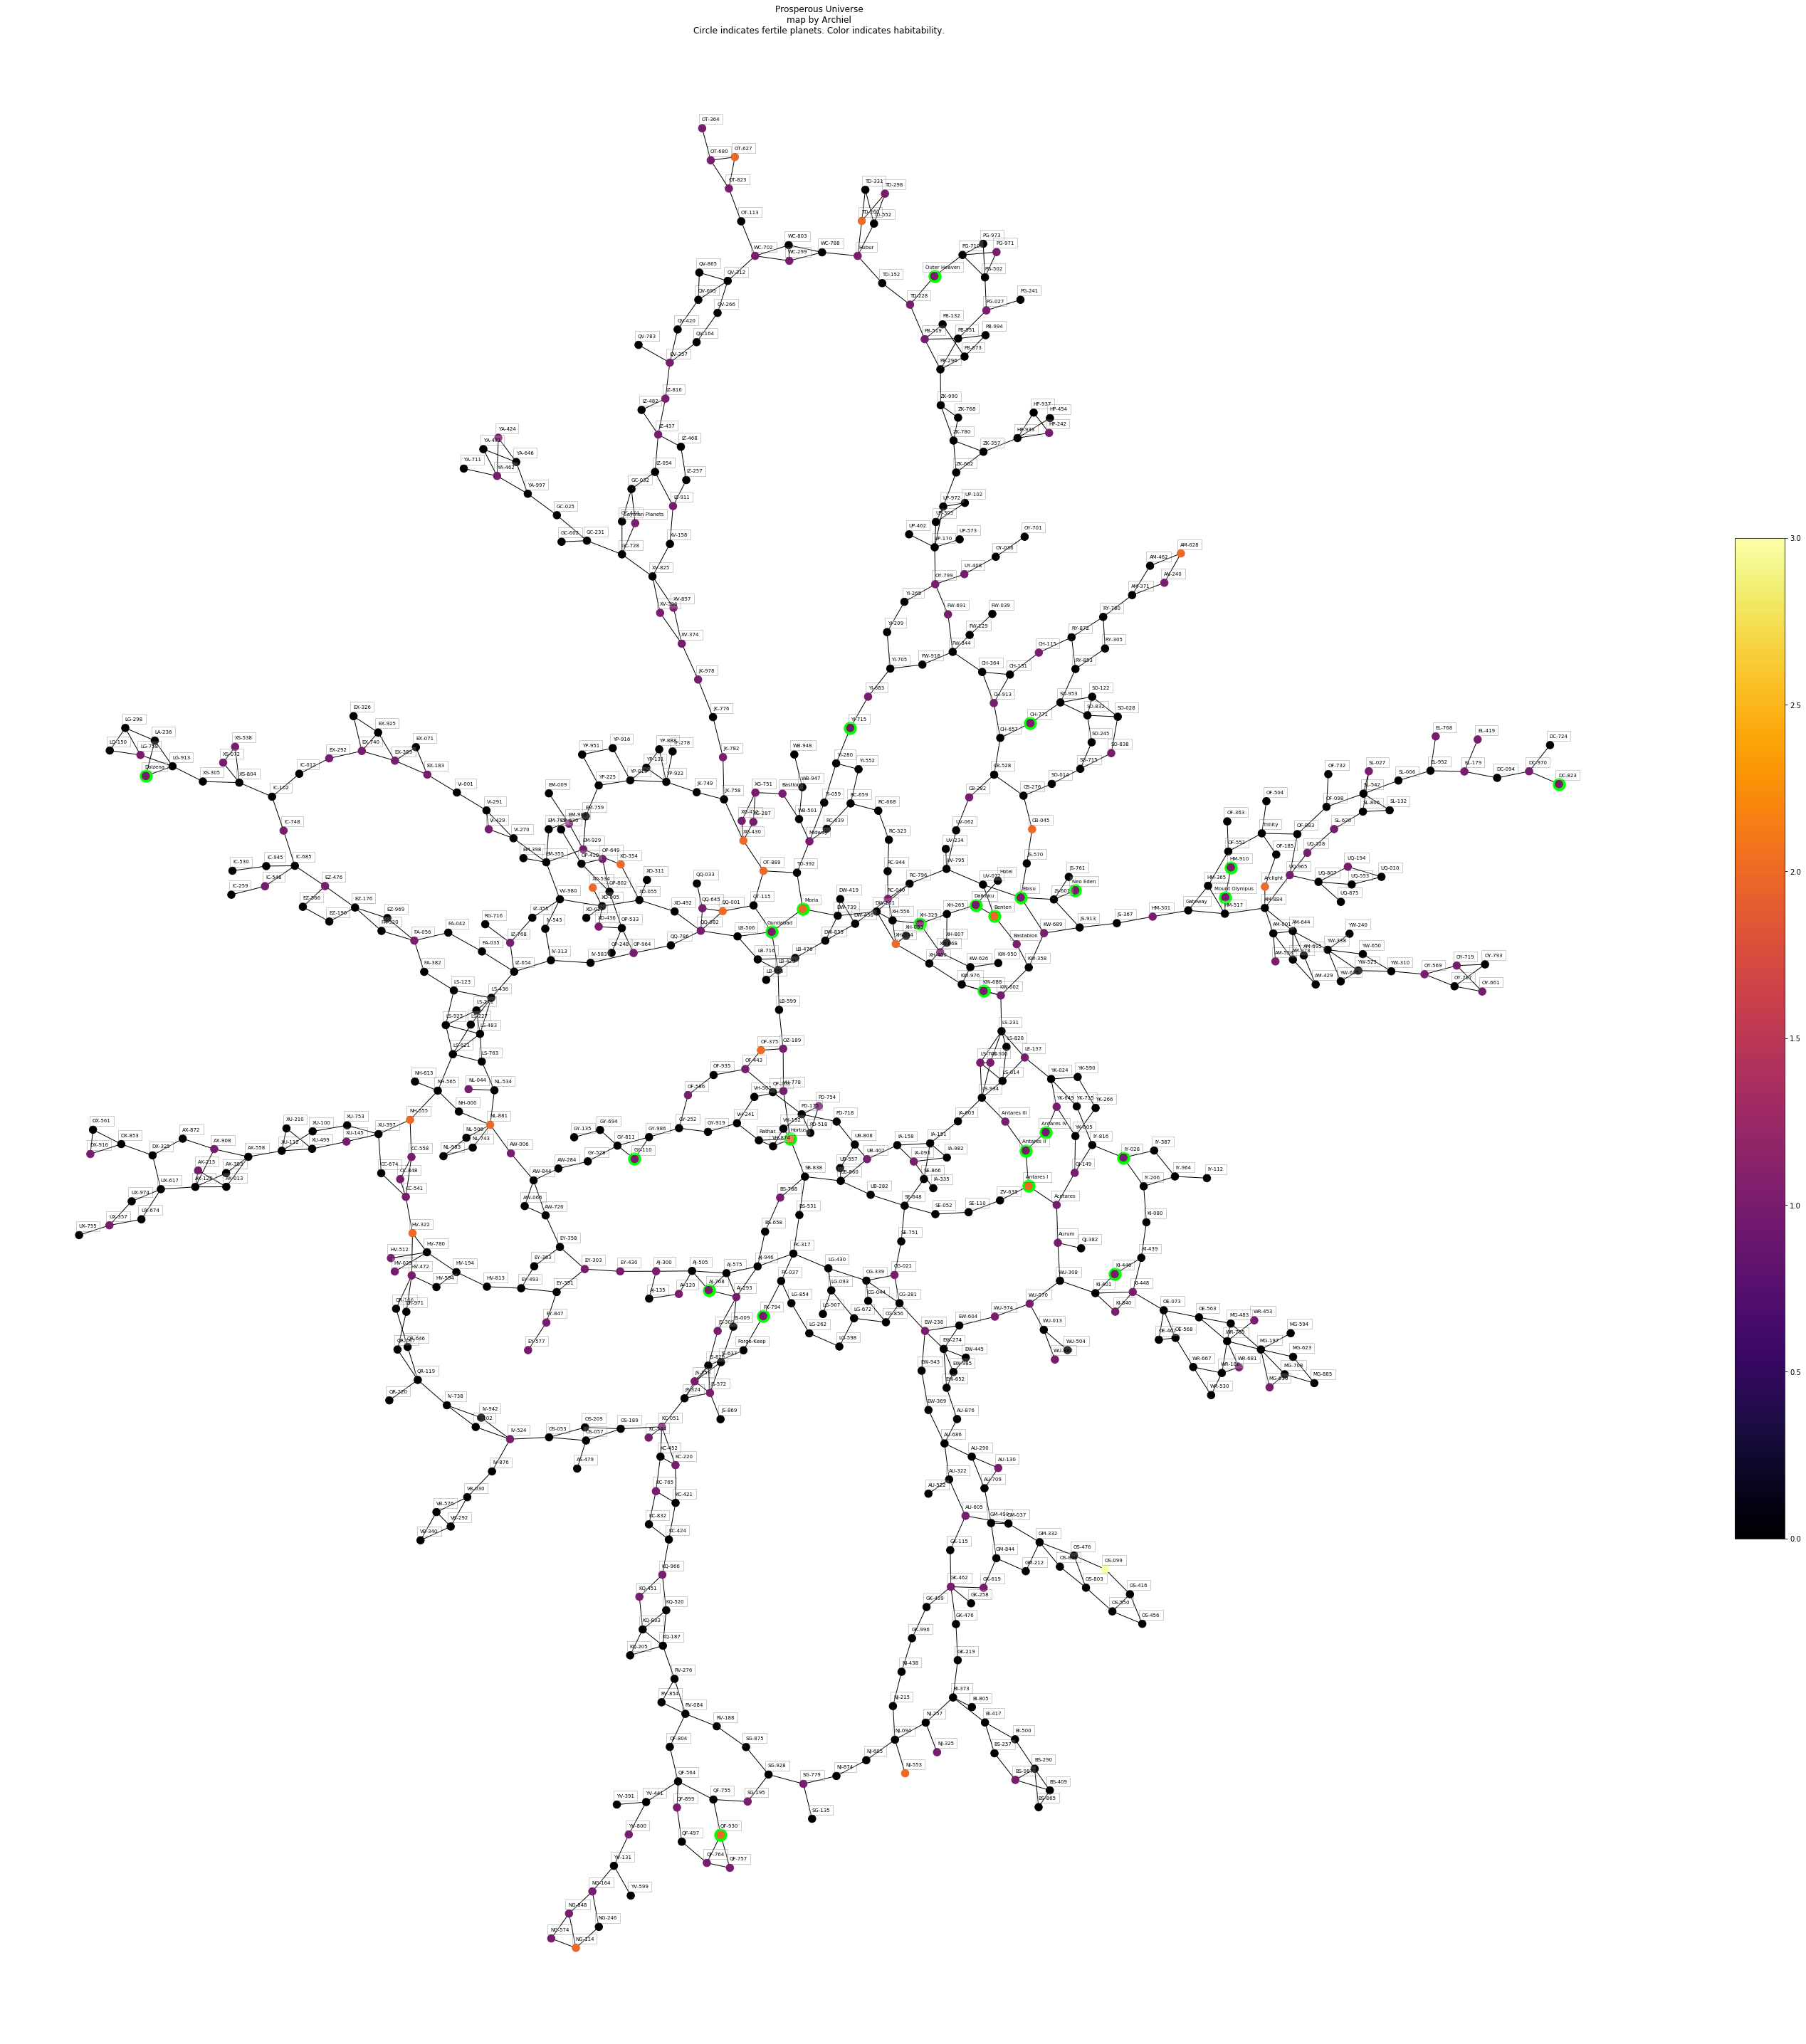

In [13]:
def drawFertile(G, pos):
    
    color_map = "inferno"
    # draw extra nodes to create outlines and dots inside our real nodes.
    matchingKeys = [k for k,v in planet_fertile.items() if float(v) >= 1]
    f1 = intersection(G.nodes, list(matchingKeys))
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='#00FF00', nodelist=f1)

    f1 = intersection(G.nodes, list(planet_habitable.keys()))
    colorListValues = [planet_habitable[k] for k in f1]
    nx.draw(G, pos, node_size=110, with_labels=False, nodelist=f1, node_color=colorListValues, cmap=color_map)

    plt.colorbar(plt.cm.ScalarMappable(cmap=color_map, norm=Normalize(0, max(colorListValues))), shrink=0.5)

graph = FilterByFunction(filterAll)
PlotGraph(graph, drawFertile, "Circle indicates fertile planets. Color indicates habitability.")

Drawing: Node count 637 edge count: 838


c:\users\kortham\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 432x288 with 0 Axes>

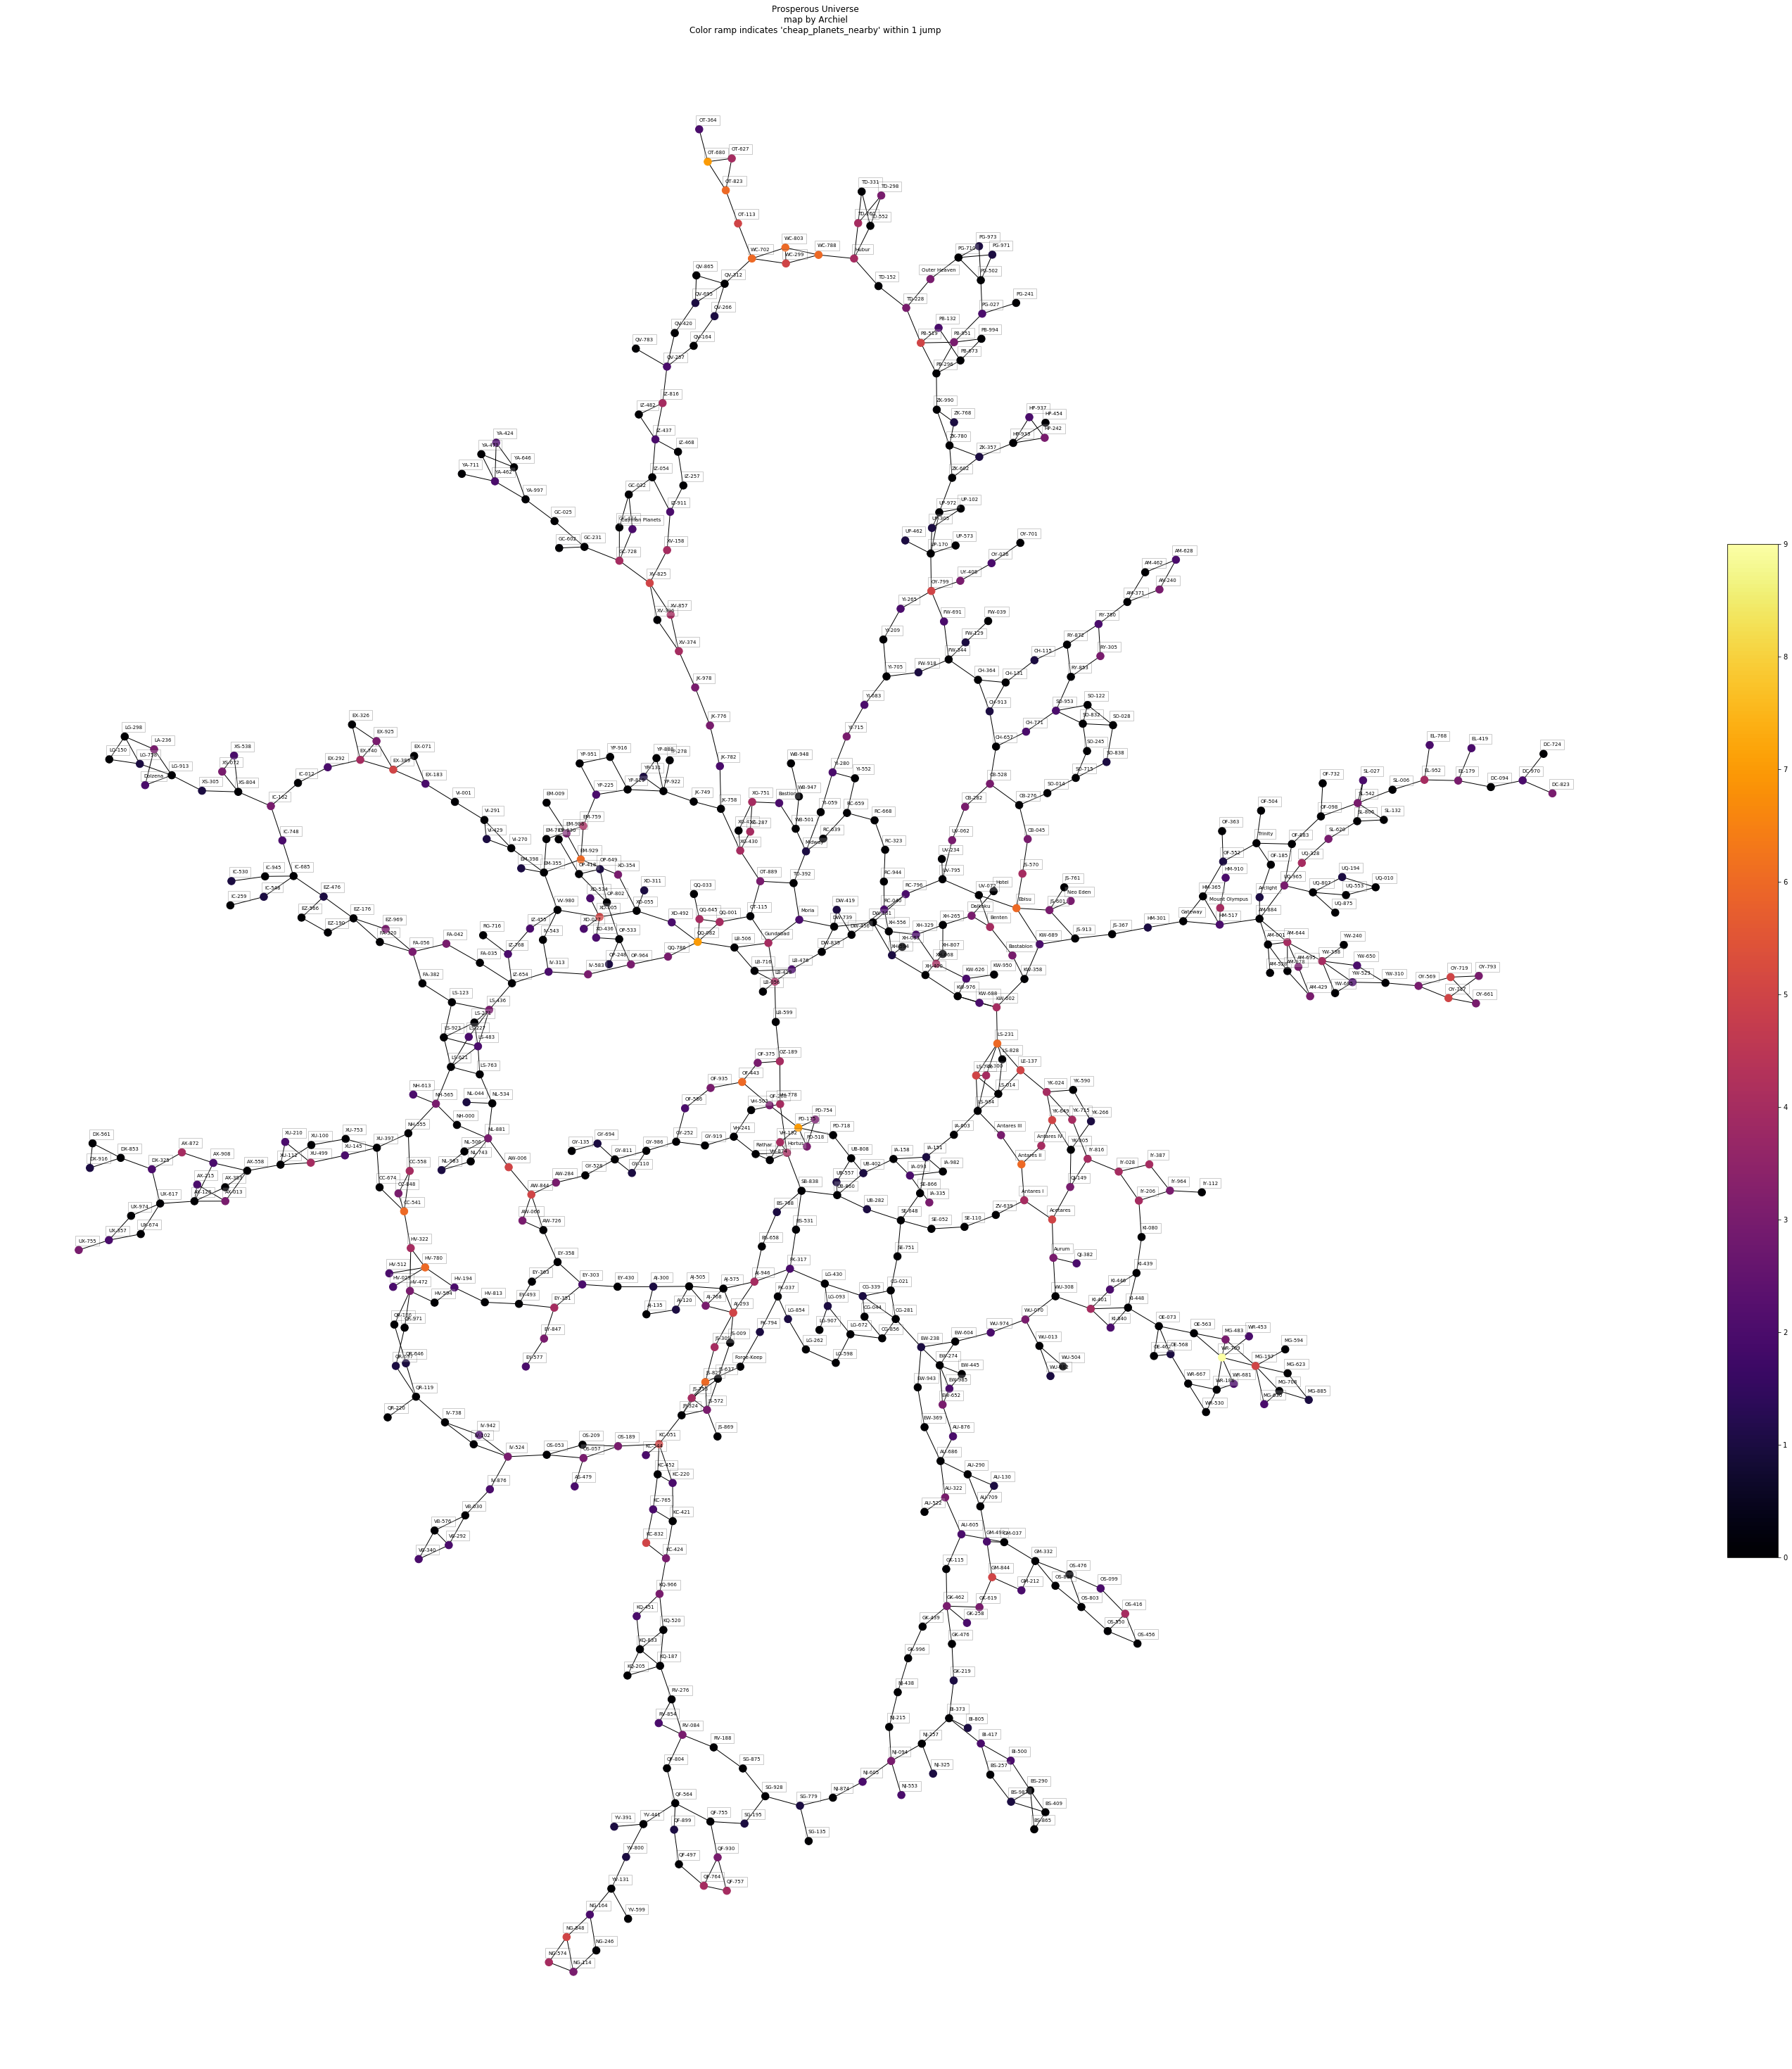

In [14]:
def drawCheapPlanetsF(G, pos):
    
    outputDict = cheap_planets_nearby_1_jump
    color_map = "inferno"
    f1 = intersection(G.nodes, list(outputDict.keys()))
    colorListValues = [outputDict[k] for k in f1]
    nx.draw(G, pos, node_size=110, with_labels=False, nodelist=f1, node_color=colorListValues, cmap=color_map)
    plt.colorbar(plt.cm.ScalarMappable(cmap=color_map, norm=Normalize(0, max(colorListValues))), shrink=0.5)

graph = FilterByFunction(filterAll)
PlotGraph(graph, drawCheapPlanetsF, "Color ramp indicates 'cheap_planets_nearby' within 1 jump")

Drawing: Node count 637 edge count: 838


c:\users\kortham\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 432x288 with 0 Axes>

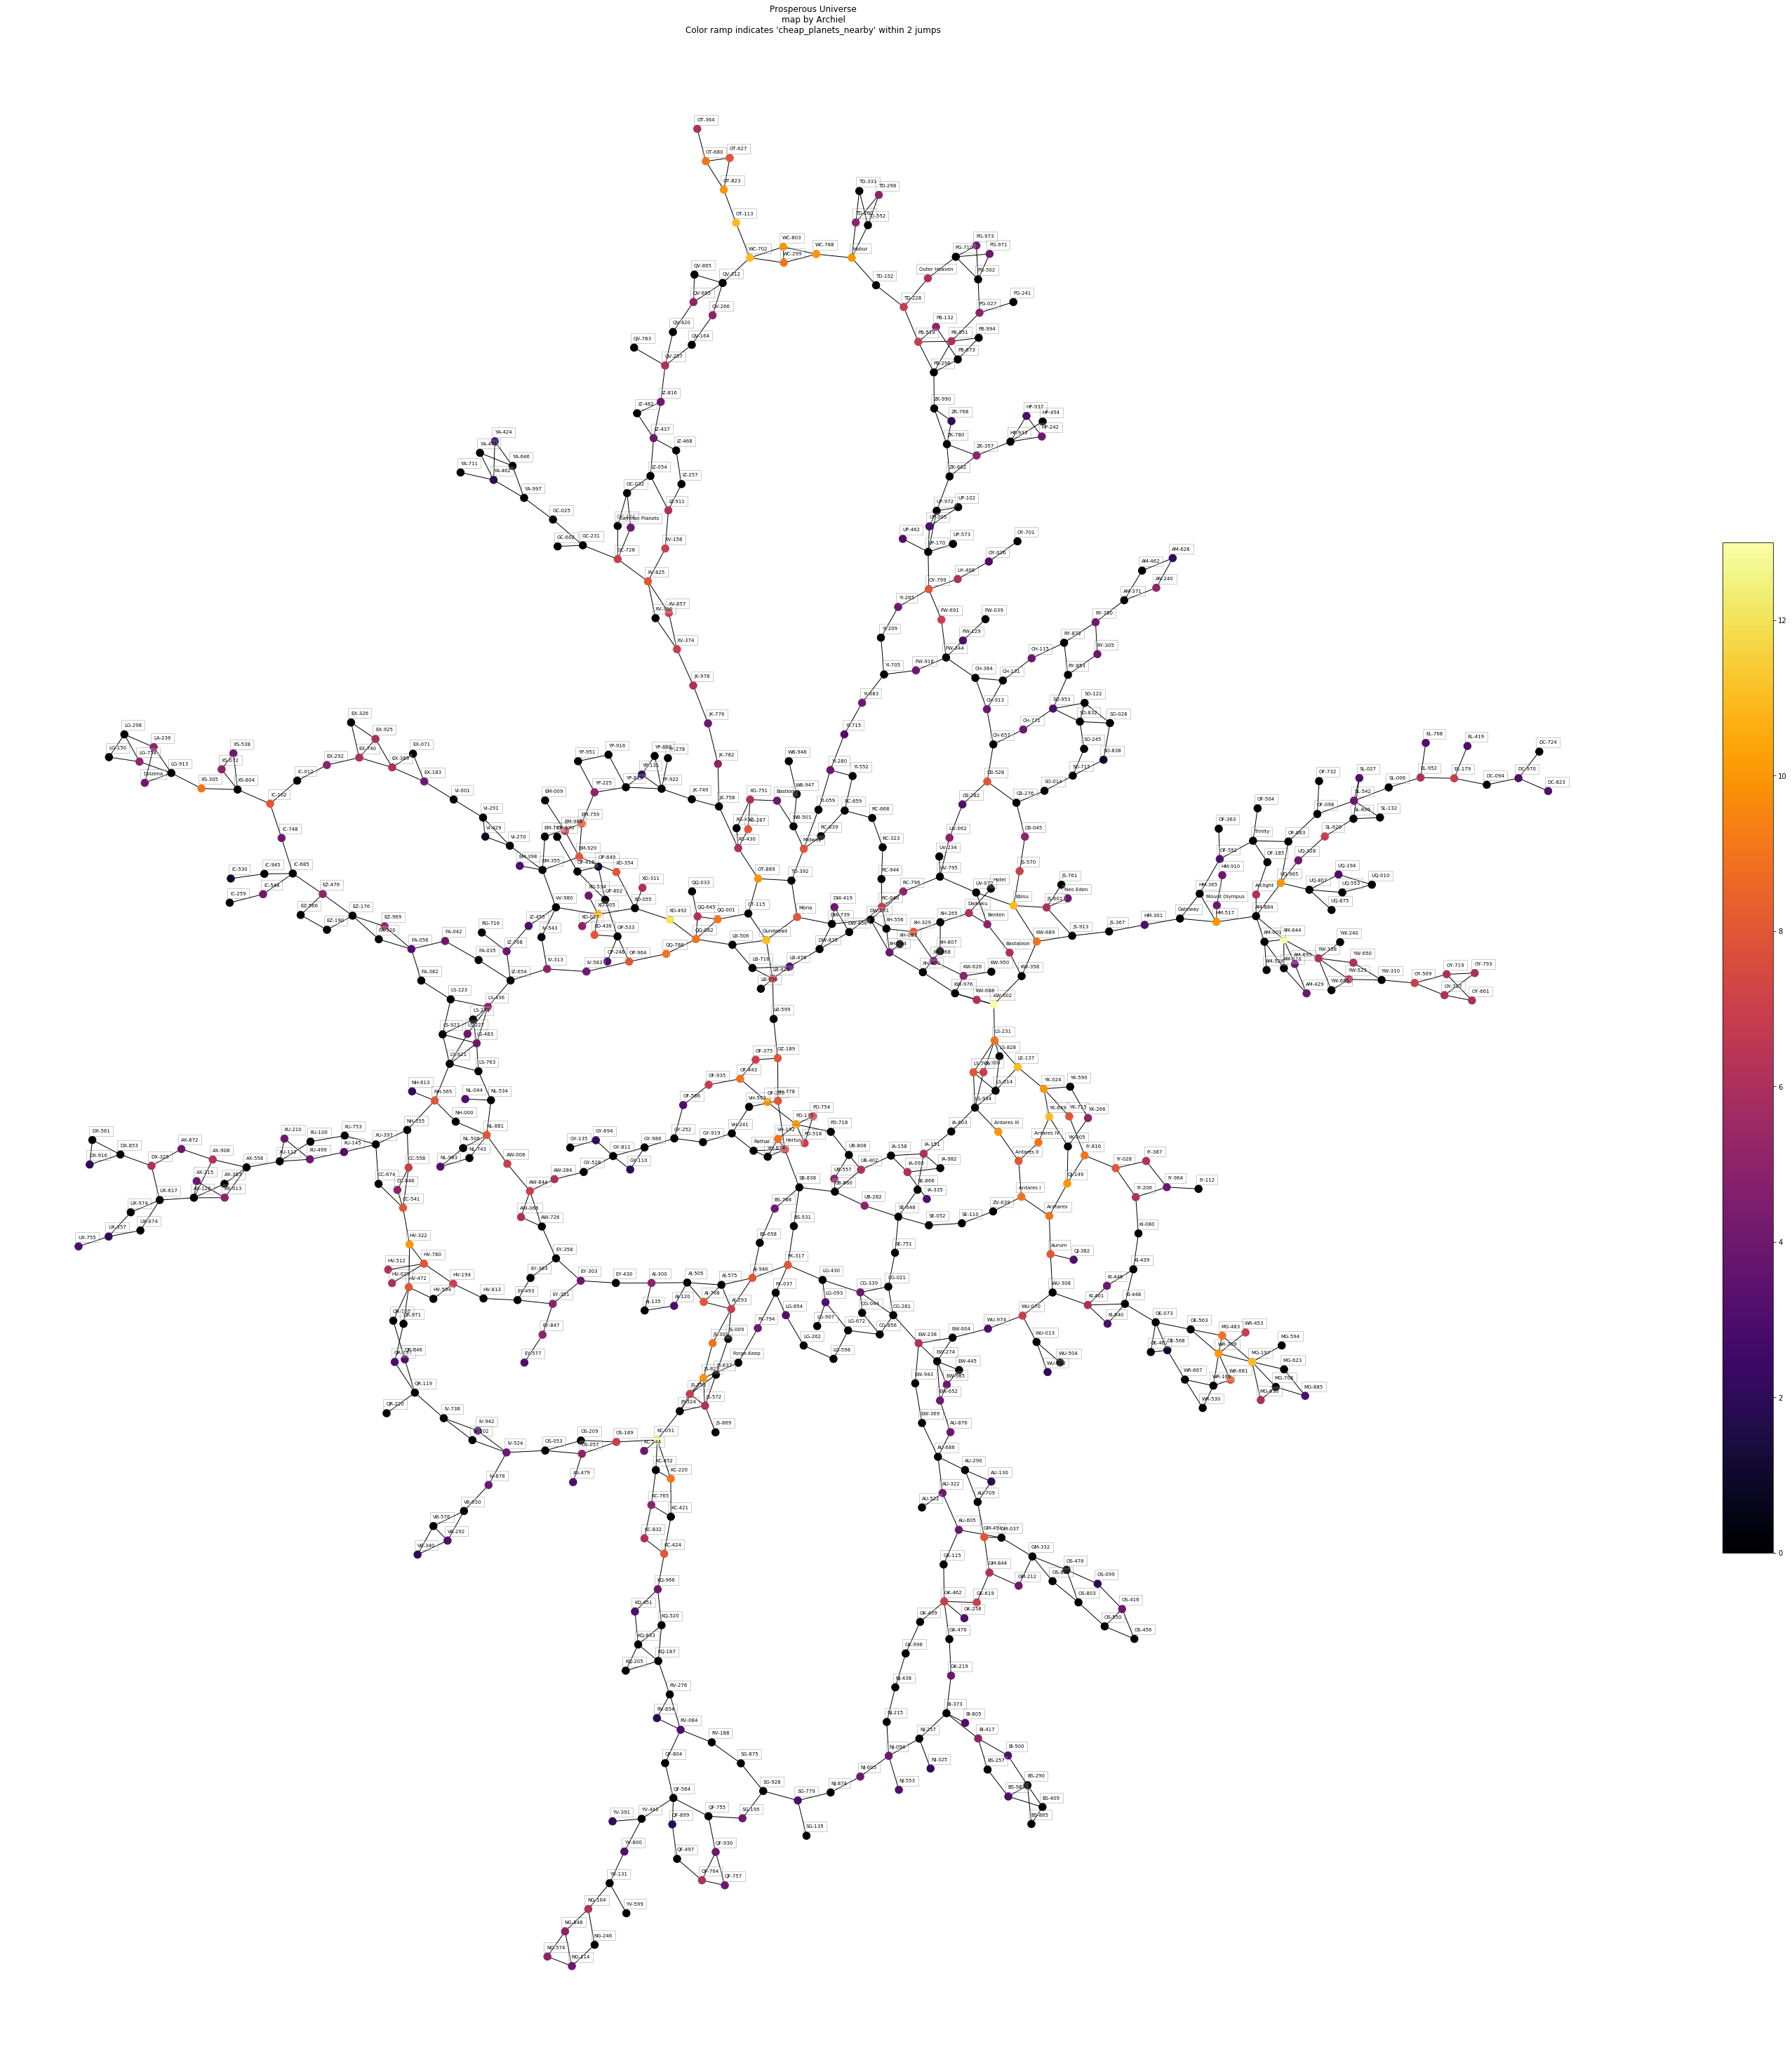

In [15]:
def drawCheapPlanetsF(G, pos):
    
    outputDict = cheap_planets_nearby_2_jumps
    color_map = "inferno"
    f1 = intersection(G.nodes, list(outputDict.keys()))
    colorListValues = [outputDict[k] for k in f1]
    nx.draw(G, pos, node_size=110, with_labels=False, nodelist=f1, node_color=colorListValues, cmap=color_map)
    plt.colorbar(plt.cm.ScalarMappable(cmap=color_map, norm=Normalize(0, max(colorListValues))), shrink=0.5)

graph = FilterByFunction(filterAll)
PlotGraph(graph, drawCheapPlanetsF, "Color ramp indicates 'cheap_planets_nearby' within 2 jumps")

In [16]:
#cheap_planets_nearby

In [17]:

def to_camel_case(text):
    return text[0]+text.title()[1:].replace("-"," ").replace("_"," ")

def EvaluatePlanet(planetDf):
    pressure = planetDf["Pressure"]
    temperature = planetDf["Temperature"]
    gravity = planetDf["Gravity"]
    surface = planetDf["Surface"]

    cost = 1688
    note = ""
    if gravity > 2.5: 
        cost += 85
        note += "High Grav (BL), "
    if gravity < 0.25:
        cost += 34*7
        note += "Low Grav (MGC), "
    if temperature > 75:
        cost += 680
        note += "High Temp (TSH), "
    if temperature < -25:
        cost += 468
        note += "Low Temp (INS), "
    if pressure > 2.0:
        cost += 272
        note += "High Press (HSE), "
    if pressure < 0.25:
        cost += 23
        note += "Low Press (SEA), "
    if not(surface):
        cost += 324
        note += "Gas (AEF), "

    if planetDf["HasChamberOfCommerce"]:
        cogc = str(planetDf["COGCPrograms"][-1]["ProgramType"])
        cogc = to_camel_case(cogc.replace("ADVERTISING_", ""))
        note = "COGC: " + cogc

    if cost < 2800:
        print("  {0:<18s} HYF Base Cost: {1:<6s} {2}".format(planetDf["PlanetName"], str(cost) + "k", note ))

def SearchNear(searchSystemNode, title, rangeN):

    print("***************************")
    print("*  Searching near " + title + " (" + searchSystemNode + ")")
    print("***************************")
    # within N jumps of ANT
    def nearSystem(systemName):
        pathLen = nx.shortest_path_length(fullGraph, searchSystemNode, systemName)
        # print("Distance from " + systemName + " is " + str(pathLen))
        return pathLen < rangeN

    g2 = FilterByFunction(nearSystem)

    # // color as distance from nascent:
    filteredValue = dict(nx.single_source_shortest_path_length(g2, searchSystemNode))
    print(searchSystemNode)
    # print(filteredValue)
    return g2

def SortAndEvalPlanets(g2, searchSystemNode):
    def funcS(x):
        return nx.shortest_path_length(g2, searchSystemNode, x)
    
    sortedNodes = list(g2.nodes)
    sortedNodes.sort(key=funcS)
    # print(sortedNodes)

    for systemName in sortedNodes:
        print()
        print(f"{systemName}      Distance {nx.shortest_path_length(g2, searchSystemNode, systemName)}")
        systemDf = FindSystem(systemName)
        for planetDf in FindPlanetsIn(systemDf):
            # evaluate planet suitability:
            EvaluatePlanet(planetDf)


g2 = SearchNear("QJ-149", "Nascent", 3) #Nascent
SortAndEvalPlanets(g2, "QJ-149")

g2 = SearchNear("SE-110", "Ice Station Alpha", 3)
SortAndEvalPlanets(g2, "SE-110")

g2 = SearchNear("KW-688", "Etherwind", 3)
SortAndEvalPlanets(g2, "KW-688")


***************************
*  Searching near Nascent (QJ-149)
***************************
QJ-149

QJ-149      Distance 0
  QJ-149b            HYF Base Cost: 2391k  High Temp (TSH), Low Press (SEA), 
  QJ-149d            HYF Base Cost: 2428k  Low Temp (INS), High Press (HSE), 
  QJ-149a            HYF Base Cost: 2368k  High Temp (TSH), 
  QJ-149f            HYF Base Cost: 2480k  Low Temp (INS), Gas (AEF), 
  QJ-149e            HYF Base Cost: 2428k  Low Temp (INS), High Press (HSE), 
  QJ-149g            HYF Base Cost: 2480k  Low Temp (INS), Gas (AEF), 
  Nascent            HYF Base Cost: 1688k  COGC: Resource Extraction

Acetares      Distance 1
  QJ-684f            HYF Base Cost: 2480k  Low Temp (INS), Gas (AEF), 
  QJ-684c            HYF Base Cost: 2428k  Low Temp (INS), High Press (HSE), 
  QJ-684e            HYF Base Cost: 2480k  Low Temp (INS), Gas (AEF), 
  QJ-684d            HYF Base Cost: 2428k  Low Temp (INS), High Press (HSE), 
  Lom Palanka        HYF Base Cost: 2368k  High 

  XH-400a            HYF Base Cost: 2179k  Low Temp (INS), Low Press (SEA), 
  XH-400e            HYF Base Cost: 2480k  Low Temp (INS), Gas (AEF), 
  XH-400b            HYF Base Cost: 2428k  Low Temp (INS), High Press (HSE), 
  XH-400c            HYF Base Cost: 2428k  Low Temp (INS), High Press (HSE), 
  XH-400d            HYF Base Cost: 2428k  Low Temp (INS), High Press (HSE), 

KW-626      Distance 2
  KW-626a            HYF Base Cost: 1960k  High Press (HSE), 
  KW-626e            HYF Base Cost: 2480k  Low Temp (INS), Gas (AEF), 
  KW-626c            HYF Base Cost: 2179k  Low Temp (INS), Low Press (SEA), 
  KW-626d            HYF Base Cost: 2428k  Low Temp (INS), High Press (HSE), 
  KW-626b            HYF Base Cost: 1960k  High Press (HSE), 

LS-231      Distance 2
  LS-231a            HYF Base Cost: 2368k  High Temp (TSH), 
  LS-231c            HYF Base Cost: 1960k  High Press (HSE), 
  LS-231e            HYF Base Cost: 2480k  Low Temp (INS), Gas (AEF), 
  LS-231f            HYF B

In [58]:
import math

#g2 = SearchNear("QJ-149", "Nascent", 3) #Nascent
#SortAndEvalPlanets(g2, "QJ-149")

def SystemDistance(systemNameA, systemNameB, min = 0, max = 100000):
    sysA = FindSystem(systemNameA)
    sysB = FindSystem(systemNameB)
#     distance = math.hypot(sysA["PositionX"] - sysB["PositionX"], sysA["PositionY"] - sysB["PositionY"], sysA["PositionZ"] - sysB["PositionZ"])
    distance = ((sysA["PositionX"] - sysB["PositionX"])**2 + (sysA["PositionY"] - sysB["PositionY"])**2 + (sysA["PositionZ"] - sysB["PositionZ"])**2)**0.5
    jumpCount = -1
    if(distance > min and distance < max):
        jumpCount = pathLen = nx.shortest_path_length(fullGraph, systemNameA, systemNameB)
    return (distance, jumpCount)

(distance, jumpCount) = SystemDistance("QJ-149", "SE-110")
print("Distance: " + str(distance) + " Jumps: " + str(jumpCount))


Distance: 277.5072213919227 Jumps: 4


In [59]:
MaxGatewayDistance = 300
allRelevantSystems = FilterByFunction(filterCloserToANT).nodes
bestPairs = []

for sys1 in allRelevantSystems:
    for sys2 in allRelevantSystems:
        (distance, jumpCount) = SystemDistance(sys1, sys2, 1, MaxGatewayDistance)
        if(jumpCount >= 0):
            bestPairs.append( (distance, jumpCount, sys1 + " to " + sys2) )
            print(sys1 + " to " + sys2 + "  Distance: " + str(distance) + " Jumps: " + str(jumpCount))
#             print("Pair count: " + str(len(bestPairs)))
            
#         if(len(bestPairs)> 5):
#             break
#     else:
#         continue
#     break
            
sorted(
    bestPairs, 
    key=lambda x: -x[1]
)



NJ-215 to RV-854  Distance: 267.6102120754807 Jumps: 9
NJ-215 to NJ-438  Distance: 59.263778336339165 Jumps: 1
NJ-215 to SG-779  Distance: 237.52189063452155 Jumps: 4
NJ-215 to GM-037  Distance: 265.87823959639553 Jumps: 7
NJ-215 to SG-135  Distance: 226.4135292589773 Jumps: 5
NJ-215 to BI-373  Distance: 121.55239520624352 Jumps: 3
NJ-215 to GK-476  Distance: 199.60202828376518 Jumps: 5
NJ-215 to GK-996  Distance: 96.08356400191398 Jumps: 2
NJ-215 to AU-522  Distance: 210.8478995733327 Jumps: 8
NJ-215 to NJ-257  Distance: 79.91065511491483 Jumps: 2
NJ-215 to AU-876  Distance: 285.79371739890655 Jumps: 9
NJ-215 to GK-115  Distance: 115.3805564597325 Jumps: 5
NJ-215 to GK-619  Distance: 187.91512506648863 Jumps: 5
NJ-215 to GK-462  Distance: 115.01950953919992 Jumps: 4
NJ-215 to AU-605  Distance: 174.47728671245036 Jumps: 6
NJ-215 to GK-258  Distance: 185.55990198251533 Jumps: 5
NJ-215 to KQ-833  Distance: 272.1163195759873 Jumps: 11
NJ-215 to AU-290  Distance: 280.7566223604613 Jumps: 9

KI-448 to IY-206  Distance: 65.72123961715411 Jumps: 3
KI-448 to Antares IV  Distance: 279.1272997559124 Jumps: 7
KI-448 to IY-028  Distance: 99.0839663973101 Jumps: 4
KI-448 to OE-563  Distance: 181.2677171162582 Jumps: 2
KI-448 to WU-308  Distance: 189.6412131321206 Jumps: 2
KI-448 to KI-080  Distance: 64.32436538387854 Jumps: 2
KI-448 to KI-446  Distance: 134.1540193626972 Jumps: 2
KI-448 to KI-439  Distance: 77.96769248185144 Jumps: 1
KI-448 to OE-568  Distance: 202.76436402276875 Jumps: 2
KI-448 to QJ-382  Distance: 184.33737904593815 Jumps: 4
KI-448 to WU-882  Distance: 175.7982097210352 Jumps: 5
KI-448 to IY-964  Distance: 122.02319021864223 Jumps: 4
KI-448 to IY-387  Distance: 126.35978512467942 Jumps: 5
KI-448 to YK-715  Distance: 219.30313732597216 Jumps: 6
KI-448 to WU-974  Distance: 271.007959244808 Jumps: 4
NG-574 to OS-053  Distance: 270.7256790121883 Jumps: 19
NG-574 to IV-876  Distance: 298.4663736198681 Jumps: 21
NG-574 to NG-848  Distance: 70.40943403657329 Jumps: 1
N

KQ-966 to LG-093  Distance: 268.00933602743635 Jumps: 12
AU-130 to AU-686  Distance: 97.98831073668659 Jumps: 2
AU-130 to WU-504  Distance: 200.386002335403 Jumps: 10
AU-130 to GM-212  Distance: 194.71345905787777 Jumps: 4
AU-130 to EW-985  Distance: 84.77307088021914 Jumps: 5
AU-130 to NJ-438  Distance: 295.8887518444352 Jumps: 8
AU-130 to EW-604  Distance: 158.77752723630337 Jumps: 6
AU-130 to WU-070  Distance: 192.21145757732907 Jumps: 8
AU-130 to CG-044  Distance: 253.15579153214685 Jumps: 8
AU-130 to EW-238  Distance: 198.8934269414177 Jumps: 5
AU-130 to GM-037  Distance: 151.22517249718075 Jumps: 3
AU-130 to GK-476  Distance: 265.3685206667204 Jumps: 6
AU-130 to EW-943  Distance: 159.01796745055827 Jumps: 4
AU-130 to GK-996  Distance: 283.81964762394864 Jumps: 7
AU-130 to AU-522  Distance: 152.00044128745245 Jumps: 4
AU-130 to GM-498  Distance: 131.59024994215602 Jumps: 2
AU-130 to CG-281  Distance: 232.99189039939841 Jumps: 6
AU-130 to EW-369  Distance: 120.23821636732231 Jumps:

Acetares to WU-013  Distance: 246.30758436406498 Jumps: 4
Acetares to Antares III  Distance: 115.43862069746383 Jumps: 3
Acetares to LS-300  Distance: 254.73917014325767 Jumps: 5
Acetares to IY-206  Distance: 225.52427384830855 Jumps: 4
Acetares to Antares IV  Distance: 71.9358614084165 Jumps: 3
Acetares to LE-137  Distance: 209.9715701211266 Jumps: 5
Acetares to LS-934  Distance: 229.8503963555421 Jumps: 4
Acetares to ZV-639  Distance: 122.66774254553042 Jumps: 2
Acetares to LS-828  Distance: 290.59438907880315 Jumps: 6
Acetares to SE-052  Distance: 226.3401086701224 Jumps: 4
Acetares to IY-028  Distance: 241.4098586888861 Jumps: 3
Acetares to CG-021  Distance: 238.92229024894516 Jumps: 7
Acetares to WU-308  Distance: 235.4491423171919 Jumps: 2
Acetares to KI-080  Distance: 207.95828694435622 Jumps: 5
Acetares to CG-339  Distance: 261.18298211206655 Jumps: 8
Acetares to KI-439  Distance: 206.16705821688913 Jumps: 5
Acetares to YK-590  Distance: 246.96974078968404 Jumps: 4
Acetares to 

IV-876 to KC-220  Distance: 238.89744820852684 Jumps: 6
IV-876 to KC-452  Distance: 299.5293155838383 Jumps: 6
IV-876 to VB-576  Distance: 115.40754254601872 Jumps: 2
IV-876 to KC-544  Distance: 253.82542701981936 Jumps: 6
IV-876 to IV-942  Distance: 99.66868768179431 Jumps: 2
IV-876 to VB-340  Distance: 198.09058281782933 Jumps: 3
IV-876 to VB-292  Distance: 142.78014138267434 Jumps: 2
IV-876 to VB-030  Distance: 72.73375473893103 Jumps: 1
IV-876 to IV-524  Distance: 102.21262269367861 Jumps: 1
IV-876 to AS-479  Distance: 146.55636658025122 Jumps: 4
IV-876 to IV-738  Distance: 157.3394185679204 Jumps: 3
IV-876 to IV-102  Distance: 128.95296977360246 Jumps: 2
YK-024 to Acetares  Distance: 221.2115467379992 Jumps: 4
YK-024 to Antares I  Distance: 218.48612126118303 Jumps: 4
YK-024 to YK-005  Distance: 86.4877753390417 Jumps: 2
YK-024 to IY-816  Distance: 237.86091243847375 Jumps: 2
YK-024 to YK-649  Distance: 64.25768049433995 Jumps: 1
YK-024 to IA-335  Distance: 288.2423489070881 Jumps

EW-985 to CG-339  Distance: 277.01257569793785 Jumps: 4
EW-985 to CG-856  Distance: 200.3924715420253 Jumps: 4
EW-985 to AU-709  Distance: 166.54703631422848 Jumps: 5
EW-985 to WU-882  Distance: 256.48659962187963 Jumps: 6
EW-985 to AU-322  Distance: 175.58652397352193 Jumps: 4
EW-985 to EW-445  Distance: 92.59726364125058 Jumps: 1
EW-985 to WU-974  Distance: 154.43628685994196 Jumps: 3
EW-985 to GM-844  Distance: 229.77045035694604 Jumps: 7
EW-985 to GK-439  Distance: 286.92282549048366 Jumps: 8
RV-276 to RV-854  Distance: 104.09305512396337 Jumps: 1
RV-276 to QF-497  Distance: 219.53277230193734 Jumps: 5
RV-276 to KQ-966  Distance: 175.53342595117982 Jumps: 3
RV-276 to SG-875  Distance: 237.2419100563774 Jumps: 3
RV-276 to KQ-451  Distance: 210.97905015791477 Jumps: 3
RV-276 to QF-804  Distance: 165.65058087156842 Jumps: 2
RV-276 to KC-051  Distance: 270.5001338129875 Jumps: 7
RV-276 to OS-209  Distance: 299.9759289895134 Jumps: 9
RV-276 to SG-195  Distance: 174.90473703398527 Jumps:

KeyboardInterrupt: 

In [52]:
len(allRelevantSystems)**2

51076

In [61]:
for index, row in df.iterrows():
    row["PositionX"]PositionY 	PositionZ]
    for connection in row["Connections"]:
        print(row["Name"] + " to " + id_to_name[connection["ConnectingId"]])
    

In [62]:
df

,Connections,SystemId,Name,NaturalId,Type,PositionX,PositionY,PositionZ,SectorId,SubSectorId,UserNameSubmitted,Timestamp
0,[{'SystemConnectionId': '014421a50088da622befe...,014421a50088da622befe22fe1b12e7e,YK-024,YK-024,K,409.509216,-16.564367,92.883606,sector-46,subsector-46-9,PIBOY314,2023-12-15T22:05:37.899584
1,[{'SystemConnectionId': '01616c4dc3d9d62eeb16b...,01616c4dc3d9d62eeb16bb863ccb3e0e,XU-753,XU-753,G,-808.953979,-183.020020,141.993225,sector-97,subsector-97-22,PIBOY314,2023-12-15T22:05:37.899584
2,[{'SystemConnectionId': '01641262587c3474f5047...,01641262587c3474f5047f71b7e5c266,IV-102,IV-102,M,-585.140198,-654.379883,106.341850,sector-102,subsector-102-4,PIBOY314,2023-12-15T22:05:37.899584
3,[{'SystemConnectionId': '01bfaf846e85228ea194e...,01bfaf846e85228ea194e31272c83cf8,CH-771,CH-771,K,527.255981,631.375122,98.094543,sector-31,subsector-31-1,PIBOY314,2023-12-15T22:05:37.899584
4,[{'SystemConnectionId': '01d637b2690bccfa60269...,01d637b2690bccfa60269f43f86a0328,SL-806,SL-806,M,871.097961,351.669769,86.662422,sector-40,subsector-40-8,PIBOY314,2023-12-15T22:05:37.899584
...,...,...,...,...,...,...,...,...,...,...,...,...
632,[{'SystemConnectionId': 'fcfa77e226f5657a84698...,fcfa77e226f5657a84698c9034282f23,YP-888,YP-888,M,-470.575897,686.081909,82.288445,sector-12,subsector-12-6,PIBOY314,2023-12-15T22:05:37.899584
633,[{'SystemConnectionId': 'fdb4dd5b90c4259d58018...,fdb4dd5b90c4259d580185b433d571aa,XG-430,XG-430,K,-235.444122,590.305237,71.216766,sector-10,subsector-10-13,PIBOY314,2023-12-15T22:05:37.899584
634,[{'SystemConnectionId': 'fe6881c67366f7e7c389f...,fe6881c67366f7e7c389fbb48624eea1,YW-240,YW-240,M,902.885742,-15.502515,87.701927,sector-42,subsector-42-16,PIBOY314,2023-12-15T22:05:37.899584
635,[{'SystemConnectionId': 'ff8bd00aa04b6cd13b038...,ff8bd00aa04b6cd13b038b5e17c0954a,WC-702,WC-702,G,-214.159714,1309.128540,112.202957,sector-18,subsector-18-10,PIBOY314,2023-12-15T22:05:37.899584
